In [1]:
# Install libs
!pip install feature-engine lightgbm xgboost
!pip install --upgrade catboost
!pip uninstall scikit-learn feature-engine -y
!pip install scikit-learn==1.2.2
!pip install feature-engine==1.3.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: feature-engine 1.3.0
Uninstalling feature-engine-1.3.0:
  Successfully uninstalled feature-engine-1.3.0
  Using cached scikit_learn-1.2.2-cp39-cp39-macosx_10_9_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp39-cp39-macosx_10_9_x86_64.whl (9.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.3.0 requires matplotlib>=3.6.2, but you have matplotlib 3.4.3 which is incompatible.
pdpbox 0.3.0 requires xgboost>=1.7.1, but you have xgboost 1.6.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.23.0 which is incompatible.
dtreeviz 2.2.1 requires graphviz>=0.9, but you have graphviz 0.8.4 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, b

In [28]:
# Standard libs Imports
import os
import sys
import time

# Data Manipulation and Numerical libs
import numpy as np
import pandas as pd

# Data Visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Scikit-Learn libs
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    VarianceThreshold
)
from scipy.stats import loguniform

# Scikit-Learn Models libs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier
)

# External Machine Learning Models libs
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Feature-Engine libs
from feature_engine.imputation import (
    ArbitraryNumberImputer,
    MeanMedianImputer,
    CategoricalImputer
)
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

# Metrics libs
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    classification_report, balanced_accuracy_score
)

# Model libs
import joblib

In [3]:
# Read the dataset
df_abt = pd.read_csv('/Users/dellacorte/py-projects/data-science/supervised-learning-pipeline-reference/databases/propensao_revenda_abt.csv')

# get the training base
df_train = df_abt.query('data_ref_safra < "2018-03-01"')

# get the evaluation base (out of time)
df_oot   = df_abt.query('data_ref_safra == "2018-03-01"')

key_vars = ['data_ref_safra', 'seller_id']
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars = ['uf']
target = 'nao_revendeu_next_6m'

features = cat_vars + num_vars

# training data
X_train = df_train[features]
y_train = df_train[target]

# test data
X_oot = df_oot[features]
y_oot = df_oot[target]

## Defining pipelines and models

In [4]:
random_state = 42

linear_models = [
    ('logistic_regression', LogisticRegression(random_state=random_state, max_iter=1000)),
    ('svm', SVC(random_state=random_state))
]

steps_linear_models = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='mean')), 
    ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())), 
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
]


tree_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=random_state)),
    ('random_forest', RandomForestClassifier(random_state=random_state)),
    ('gb', GradientBoostingClassifier(random_state=random_state)),
    ('xgb', XGBClassifier(random_state=random_state)),
    ('lgbm', LGBMClassifier(random_state=random_state)),
    ('catboost', CatBoostClassifier(random_state=random_state))
]

steps_tree_models = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='mean')),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    
]

## Defining the metrics

In [5]:
df_results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
df_results

,accuracy,precision,recall,f1,roc_auc


## Automating the entire process

In [6]:
def train_model(model, steps, X_train, y_train, cv, random_state, n_jobs=-1):
    pipeline = Pipeline(steps=steps + [model])
    CV_result = cross_validate(
                            estimator=pipeline, 
                            X=X_train,
                            y=y_train,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                            cv=cv,
                            n_jobs=-1)

    df_aux = pd.DataFrame(CV_result)
    dfar = df_aux.mean()

    return [
            dfar.loc['test_accuracy'], 
            dfar.loc['test_precision'], 
            dfar.loc['test_recall'], 
            dfar.loc['test_f1'], 
            dfar.loc['test_roc_auc']
    ]

In [7]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

for model in linear_models:
    model_name = model[0]
    print(f'Trainning {model_name} ...', end=' ')
    aux = train_model(model, steps_linear_models, X_train, y_train, skf, random_state)
    df_results.loc[model_name] = aux
    print('OK')

for model in tree_models:
    model_name = model[0]
    print(f'Trainning {model_name} ...', end=' ')
    aux = train_model(model, steps_tree_models, X_train, y_train, skf, random_state)
    df_results.loc[model_name] = aux
    print('OK')

Trainning logistic_regression ... 

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' 

OK
Trainning svm ... 

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


OK
Trainning decision_tree ... 

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


OK
Trainning random_forest ... 

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


OK
Trainning gb ... OK
Trainning xgb ... OK
Trainning lgbm ... OK
Trainning catboost ... [LightGBM] [Info] Number of positive: 1066, number of negative: 1730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 2796, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381259 -> initscore=-0.484208
[LightGBM] [Info] Start training from score -0.484208
Learning rate set to 0.015981
0:	learn: 0.6818280	total: 67ms	remaining: 1m 6s
1:	learn: 0.6715497	total: 68.9ms	remaining: 34.4s
2:	learn: 0.6608124	total: 70.6ms	remaining: 23.5s
3:	learn: 0.6508268	total: 72.5ms	remaining: 18.1s
4:	learn: 0.6408444	total: 74.4ms	remaining: 14.8s
5:	learn: 0.6313787	total: 76.9ms	remaining: 12.7s
6:	learn: 0.6227147	total: 78.8ms	remaining: 11.2s
7:	learn: 0.6142639	total: 80.7ms	re

271:	learn: 0.3398469	total: 515ms	remaining: 1.38s
272:	learn: 0.3398271	total: 516ms	remaining: 1.37s
273:	learn: 0.3398073	total: 518ms	remaining: 1.37s
274:	learn: 0.3397367	total: 520ms	remaining: 1.37s
275:	learn: 0.3395836	total: 521ms	remaining: 1.37s
276:	learn: 0.3394274	total: 522ms	remaining: 1.36s
277:	learn: 0.3392029	total: 524ms	remaining: 1.36s
278:	learn: 0.3389498	total: 525ms	remaining: 1.36s
279:	learn: 0.3387963	total: 526ms	remaining: 1.35s
280:	learn: 0.3386535	total: 528ms	remaining: 1.35s
281:	learn: 0.3384747	total: 529ms	remaining: 1.35s
282:	learn: 0.3383510	total: 530ms	remaining: 1.34s
283:	learn: 0.3382619	total: 532ms	remaining: 1.34s
284:	learn: 0.3381858	total: 533ms	remaining: 1.34s
285:	learn: 0.3381226	total: 535ms	remaining: 1.33s
286:	learn: 0.3380783	total: 537ms	remaining: 1.33s
287:	learn: 0.3380450	total: 538ms	remaining: 1.33s
288:	learn: 0.3379721	total: 539ms	remaining: 1.33s
289:	learn: 0.3379242	total: 540ms	remaining: 1.32s
290:	learn: 

OK
CPU times: user 179 ms, sys: 268 ms, total: 447 ms
Wall time: 12.7 s


In [8]:
df_results.sort_values(by='roc_auc', ascending=False)

,accuracy,precision,recall,f1,roc_auc
catboost,0.844635,0.808709,0.776278,0.791764,0.913226
random_forest,0.836624,0.798771,0.763530,0.780582,0.912172
xgb,0.840629,0.799122,0.777762,0.787895,0.910180
lgbm,0.835479,0.791366,0.772535,0.781464,0.907614
gb,0.832904,0.789713,0.765771,0.777198,0.907262
logistic_regression,0.825179,0.850291,0.656920,0.741007,0.898444
svm,0.829757,0.822120,0.707209,0.759838,0.891748
decision_tree,0.776252,0.703995,0.713213,0.708302,0.764132


In [11]:
# Best model was Catboost, so:

best_model = Pipeline(steps=steps_tree_models + [tree_models[-1]])
best_model

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer',
                 CategoricalImputer(fill_value='missing', variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7fc628af2b80>)])

In [12]:
best_model.fit(X_train, y_train)

Learning rate set to 0.017579
0:	learn: 0.6799136	total: 68ms	remaining: 1m 7s
1:	learn: 0.6681828	total: 70.2ms	remaining: 35s
2:	learn: 0.6565842	total: 72.5ms	remaining: 24.1s
3:	learn: 0.6453770	total: 74.5ms	remaining: 18.5s
4:	learn: 0.6342850	total: 76.3ms	remaining: 15.2s
5:	learn: 0.6237834	total: 78.1ms	remaining: 12.9s
6:	learn: 0.6139152	total: 79.9ms	remaining: 11.3s
7:	learn: 0.6039922	total: 81.7ms	remaining: 10.1s
8:	learn: 0.5947968	total: 83.5ms	remaining: 9.19s
9:	learn: 0.5856757	total: 85.1ms	remaining: 8.43s
10:	learn: 0.5766364	total: 86.7ms	remaining: 7.8s
11:	learn: 0.5680487	total: 88.3ms	remaining: 7.27s
12:	learn: 0.5595120	total: 90.1ms	remaining: 6.84s
13:	learn: 0.5525649	total: 91.6ms	remaining: 6.45s
14:	learn: 0.5447315	total: 93.1ms	remaining: 6.12s
15:	learn: 0.5382335	total: 94.5ms	remaining: 5.81s
16:	learn: 0.5320354	total: 95.9ms	remaining: 5.54s
17:	learn: 0.5254555	total: 97.4ms	remaining: 5.31s
18:	learn: 0.5192068	total: 98.8ms	remaining: 5.1

289:	learn: 0.3418409	total: 391ms	remaining: 958ms
290:	learn: 0.3417944	total: 393ms	remaining: 956ms
291:	learn: 0.3416919	total: 394ms	remaining: 954ms
292:	learn: 0.3416268	total: 395ms	remaining: 952ms
293:	learn: 0.3415130	total: 396ms	remaining: 950ms
294:	learn: 0.3413560	total: 397ms	remaining: 948ms
295:	learn: 0.3412101	total: 398ms	remaining: 946ms
296:	learn: 0.3410604	total: 399ms	remaining: 944ms
297:	learn: 0.3409522	total: 400ms	remaining: 942ms
298:	learn: 0.3408458	total: 401ms	remaining: 939ms
299:	learn: 0.3407367	total: 402ms	remaining: 937ms
300:	learn: 0.3405078	total: 403ms	remaining: 936ms
301:	learn: 0.3403914	total: 404ms	remaining: 934ms
302:	learn: 0.3402269	total: 405ms	remaining: 932ms
303:	learn: 0.3400549	total: 407ms	remaining: 931ms
304:	learn: 0.3399641	total: 408ms	remaining: 929ms
305:	learn: 0.3398875	total: 409ms	remaining: 927ms
306:	learn: 0.3398632	total: 410ms	remaining: 926ms
307:	learn: 0.3397216	total: 411ms	remaining: 924ms
308:	learn: 

466:	learn: 0.3221526	total: 587ms	remaining: 670ms
467:	learn: 0.3221320	total: 588ms	remaining: 668ms
468:	learn: 0.3220838	total: 589ms	remaining: 667ms
469:	learn: 0.3219480	total: 590ms	remaining: 665ms
470:	learn: 0.3218863	total: 591ms	remaining: 664ms
471:	learn: 0.3218433	total: 592ms	remaining: 662ms
472:	learn: 0.3216833	total: 593ms	remaining: 661ms
473:	learn: 0.3216170	total: 594ms	remaining: 659ms
474:	learn: 0.3215876	total: 595ms	remaining: 658ms
475:	learn: 0.3213293	total: 596ms	remaining: 657ms
476:	learn: 0.3211194	total: 598ms	remaining: 656ms
477:	learn: 0.3209627	total: 599ms	remaining: 655ms
478:	learn: 0.3207396	total: 600ms	remaining: 653ms
479:	learn: 0.3206303	total: 601ms	remaining: 652ms
480:	learn: 0.3205601	total: 603ms	remaining: 650ms
481:	learn: 0.3203765	total: 604ms	remaining: 649ms
482:	learn: 0.3202735	total: 605ms	remaining: 648ms
483:	learn: 0.3201560	total: 607ms	remaining: 647ms
484:	learn: 0.3198725	total: 608ms	remaining: 645ms
485:	learn: 

652:	learn: 0.2968260	total: 783ms	remaining: 416ms
653:	learn: 0.2967207	total: 784ms	remaining: 415ms
654:	learn: 0.2966964	total: 786ms	remaining: 414ms
655:	learn: 0.2965230	total: 787ms	remaining: 412ms
656:	learn: 0.2964358	total: 788ms	remaining: 411ms
657:	learn: 0.2963736	total: 789ms	remaining: 410ms
658:	learn: 0.2962695	total: 790ms	remaining: 409ms
659:	learn: 0.2962086	total: 791ms	remaining: 407ms
660:	learn: 0.2960485	total: 792ms	remaining: 406ms
661:	learn: 0.2958859	total: 794ms	remaining: 405ms
662:	learn: 0.2957325	total: 795ms	remaining: 404ms
663:	learn: 0.2955556	total: 796ms	remaining: 403ms
664:	learn: 0.2954338	total: 797ms	remaining: 402ms
665:	learn: 0.2953356	total: 798ms	remaining: 400ms
666:	learn: 0.2952008	total: 800ms	remaining: 399ms
667:	learn: 0.2951631	total: 801ms	remaining: 398ms
668:	learn: 0.2950503	total: 803ms	remaining: 397ms
669:	learn: 0.2948470	total: 804ms	remaining: 396ms
670:	learn: 0.2947139	total: 805ms	remaining: 395ms
671:	learn: 

834:	learn: 0.2767509	total: 979ms	remaining: 193ms
835:	learn: 0.2765893	total: 980ms	remaining: 192ms
836:	learn: 0.2764703	total: 981ms	remaining: 191ms
837:	learn: 0.2763663	total: 983ms	remaining: 190ms
838:	learn: 0.2762877	total: 984ms	remaining: 189ms
839:	learn: 0.2761404	total: 985ms	remaining: 188ms
840:	learn: 0.2760078	total: 986ms	remaining: 186ms
841:	learn: 0.2758473	total: 987ms	remaining: 185ms
842:	learn: 0.2757693	total: 988ms	remaining: 184ms
843:	learn: 0.2756000	total: 989ms	remaining: 183ms
844:	learn: 0.2754333	total: 990ms	remaining: 182ms
845:	learn: 0.2753700	total: 991ms	remaining: 180ms
846:	learn: 0.2753527	total: 992ms	remaining: 179ms
847:	learn: 0.2753323	total: 993ms	remaining: 178ms
848:	learn: 0.2751996	total: 994ms	remaining: 177ms
849:	learn: 0.2751089	total: 996ms	remaining: 176ms
850:	learn: 0.2750652	total: 997ms	remaining: 175ms
851:	learn: 0.2748314	total: 998ms	remaining: 173ms
852:	learn: 0.2747116	total: 999ms	remaining: 172ms
853:	learn: 

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer',
                 CategoricalImputer(fill_value='missing', variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7fc628af2b80>)])

In [13]:
y_pred_oot = best_model.predict(X_oot)

In [14]:
y_proba_oot = best_model.predict_proba(X_oot)[:,1]

In [15]:
roc_auc_oot = roc_auc_score(y_oot, y_proba_oot)
print(f'RoC-AUC: {roc_auc_oot:.3f}')

RoC-AUC: 0.922


In [29]:
print(classification_report(y_oot, y_pred_oot))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1153
           1       0.81      0.82      0.82       721

    accuracy                           0.86      1874
   macro avg       0.85      0.85      0.85      1874
weighted avg       0.86      0.86      0.86      1874



In [30]:
print(f'Acurácia OOT: {accuracy_score(y_oot, y_pred_oot):.4f}')
print(f'Acurácia Balanceada OOT: {balanced_accuracy_score(y_oot, y_pred_oot):.4f}')

Acurácia OOT: 0.8586
Acurácia Balanceada OOT: 0.8516


## Explaining the Model

### Shape Values

Shap Values ​​is an agnostic model explanation method, especially used to interpret models considered "black box", such as tree-based models (random forest, xgboost, lightgbm, catboost).

In [31]:
!pip install shap

In [33]:
import shap
print(shap.__version__)

explainer = shap.TreeExplainer(best_model[-1])
X_oot_transformed = best_model[:-1].transform(X_oot)

0.46.0


In [34]:
shap_values = explainer.shap_values(X_oot_transformed)

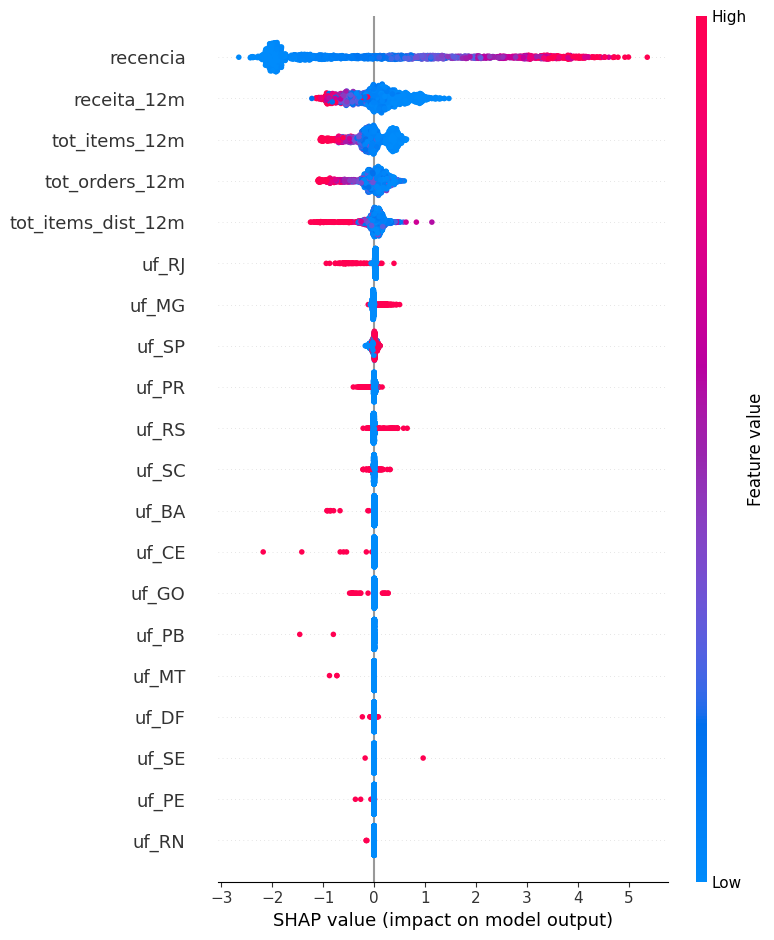

In [35]:
shap.summary_plot(shap_values, X_oot_transformed)

The variables are ordered from top to bottom in order of importance for the model.

Looking at the most important variable, `recency`, the higher its value, the greater the positive impact on the model output. In other words, the greater the `recency`, the greater the propensity not to resell!

Interpretation for the second most important variable `revenue_12m`: the lower the `revenue_12m`, the greater the propensity of not reselling!

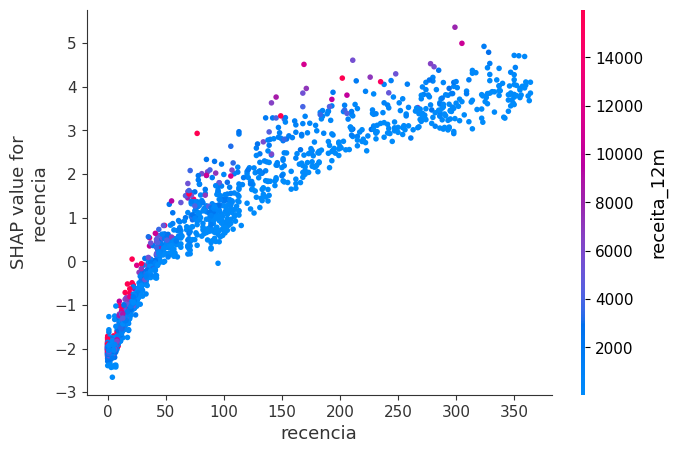

In [36]:
shap.dependence_plot('recencia', shap_values, X_oot_transformed, interaction_index='receita_12m')

The higher the `recency` and the lower the `revenue_12m`, the greater the propensity not to resell.

We can also create a cutoff to trigger communication. For example, above 50 days of `recency`, the seller already enters the region with a high chance of not reselling. We can then contact you to retain the seller when the seller's 'recency' is greater than or equal to 50 days.

## Save the model for later use

In [37]:
!pip install joblib

In [38]:
import joblib

In [39]:
!mkdir '/Users/dellacorte/py-projects/data-science/supervised-learning-pipeline-reference/classification-III/models'

In [40]:
path = '/Users/dellacorte/py-projects/data-science/supervised-learning-pipeline-reference/classification-III/models/best_model_olist_20250122.joblib'
joblib.dump(best_model, path)

['/Users/dellacorte/py-projects/data-science/supervised-learning-pipeline-reference/classification-III/models/best_model_olist_20250122.joblib']